In [1]:
# Импортируем необходимые библиотеки, в том числе pandahouse

import pandahouse as ph

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Задаем параметры соединения с базой данных "default" на удаленном сервере

connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
# Задаем параметры соединения с базой данных "test" на удаленном сервере

connection_test = dict(database='test',
                  host='http://clickhouse.beslan.pro:8080',
                  user='student-rw',
                  password='656e2b0c9c')

In [4]:
# Составляем пробный запрос

q = '''
    SELECT count()
    FROM default.ldn_listings
    '''

In [5]:
# Выводим результат запроса к БД "default"

q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,count()
0,85207


#### Задача №1

Выгрузите из таблицы ldn_listings данные о цене в зависимости от типа жилья. 

Необходимые столбцы:

price – цена за ночь

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [6]:
# Формируем запрос к БД

q = '''
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
    FROM default.ldn_listings
    ORDER BY
        id
    LIMIT 1000
    '''

In [7]:
# Выгружаем данные из БД по запросу

q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0


In [8]:
q_test.query('room_type == "Private room"') \
      .quantile(q=0.75)

price    70.0
Name: 0.75, dtype: float64

#### Задача №2

К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). 
В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Постройте график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья.

In [9]:
# Формируем запрос к БД

q = '''
    SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toFloat32OrNull(review_scores_rating) AS review_sc_rat
    FROM default.ldn_listings
    WHERE
        isNotNull(review_sc_rat )
    ORDER BY
        id
    LIMIT 1000
    '''

In [10]:
# Выгружаем данные из БД по запросу

q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test.head()

,room_type,price,review_sc_rat
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [11]:
q_test_grouped = q_test.groupby('room_type', as_index=False) \
      .agg({'price': 'mean', 'review_sc_rat': 'mean'})
q_test_grouped

,room_type,price,review_sc_rat
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


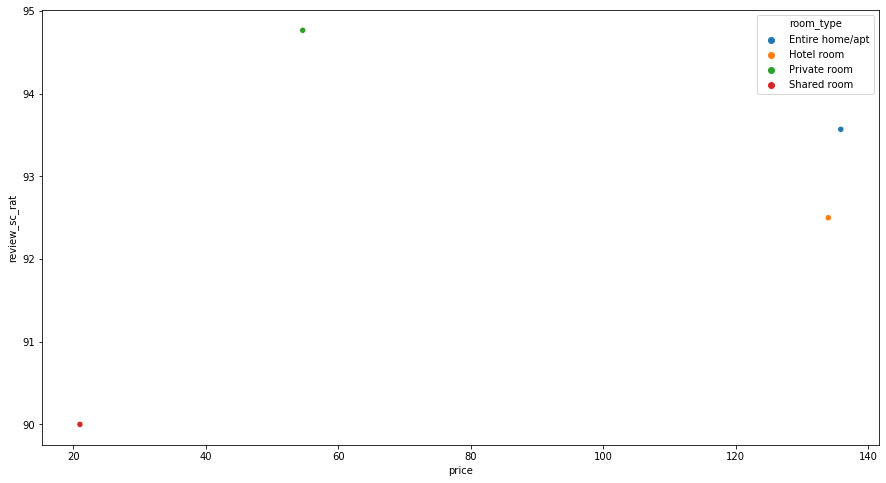

In [12]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='price', y='review_sc_rat', hue = 'room_type', data = q_test_grouped)

#### Задача №3

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления.Для каждого уникального пользователя выгрузите только две колонки:

host_id – идентификатор хозяина (уникальный)
host_verifications – какими способами хост подтвердил свой профиль

Затем обработайте столбец host_verifications:

В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). 

Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

Далее посчитайте сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [13]:
# Формируем запрос: нам необходимы хозяева, которые предлагают различные "впечатления"

q = '''
    SELECT
        DISTINCT host_id,
        host_verifications
    FROM default.ldn_listings
    WHERE
        experiences_offered != 'none'
    '''

In [14]:
# Выгружаем данные по сформированному запросу из БД

q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [15]:
# Производим обработку строковых данных

q_test.host_verifications = q_test.host_verifications.str.replace('[', '').str.replace(']', '')

In [16]:
# Разбиваем каждую строку в список

q_test.host_verifications = q_test.host_verifications.str.split(', ')

In [17]:
q_test.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [18]:
# Разбиваем список каждой строки с помощью метода .explode()

q_test = q_test.explode(column='host_verifications').reset_index(drop=True)
q_test

,host_id,host_verifications
0,54730,'email'
1,54730,'phone'
2,54730,'facebook'
3,54730,'reviews'
4,54730,'offline_government_id'
...,...,...
7971,26917573,'phone'
7972,26917573,'reviews'
7973,26917573,'manual_offline'
7974,26917573,'jumio'


In [19]:
# Производим группировку по способу верификации и считаем количество

q_test.groupby('host_verifications', as_index=False) \
      .agg({'host_id': 'count'})

,host_verifications,host_id
0,'email',1345
1,'facebook',270
2,'google',34
3,'government_id',1196
4,'identity_manual',227
5,'jumio',1115
6,'kba',27
7,'manual_offline',70
8,'manual_online',16
9,'offline_government_id',469


#### Задача №4

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. 

Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. 

Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. 

Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [20]:
# Формируем запрос к БД

q = '''
   SELECT
    neighbourhood_cleansed,
    experiences_offered,
    count(id) AS experiences_count
    FROM default.ldn_listings
    WHERE
    experiences_offered != 'none'
    GROUP BY
    neighbourhood_cleansed,
    experiences_offered
    ORDER BY
    experiences_count DESC
    '''

In [21]:
# Выгружаем данные из БД по запросу

q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [22]:
experience_count = q_test.pivot(index='neighbourhood_cleansed', 
                                columns='experiences_offered', 
                                values='experiences_count').fillna(0)
experience_count

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,1.0,0.0,0.0,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,0.0,0.0,0.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,1.0,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,1.0,0.0
Croydon,2.0,3.0,0.0,4.0
Ealing,6.0,13.0,1.0,5.0


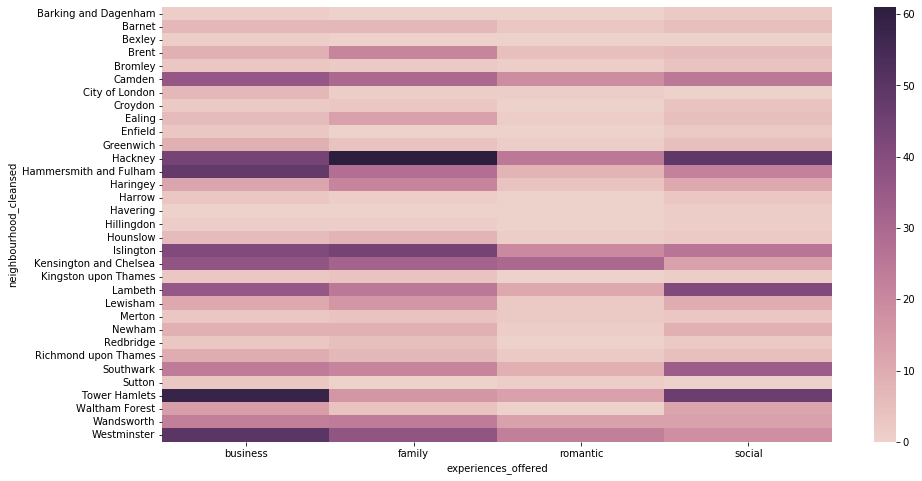

In [23]:
plt.figure(figsize=(15,8))
sns.heatmap(experience_count, cmap=sns.cubehelix_palette(as_cmap=True))

#### Задача №5

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

price – цена за ночь

first_review – дата первого отзыва


Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

In [25]:
# Формируем запрос к БД

q = """
    SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr,
    first_review AS first_review_corr
    FROM default.ldn_listings
    WHERE
    first_review_corr > '2010-01-01'
    LIMIT 1000
    """

In [26]:
# Выгружаем данные из БД

q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,room_type,price_corr,first_review_corr
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [27]:
q_test.dtypes

room_type             object
price_corr           float32
first_review_corr     object
dtype: object

In [28]:
q_test.first_review_corr = q_test.first_review_corr.apply(lambda c: c.split('-')[0])
q_test.head()

,room_type,price_corr,first_review_corr
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010


In [29]:
q_test_agg = q_test.groupby(['room_type', 'first_review_corr'], as_index=False) \
                   .agg({'price_corr': 'mean'}) \
                   .sort_values('first_review_corr')
q_test_agg.head()

,room_type,first_review_corr,price_corr
0,Entire home/apt,2010,103.500000
13,Private room,2010,56.428570
11,Hotel room,2010,88.000000
1,Entire home/apt,2011,128.792450
14,Private room,2011,52.607143


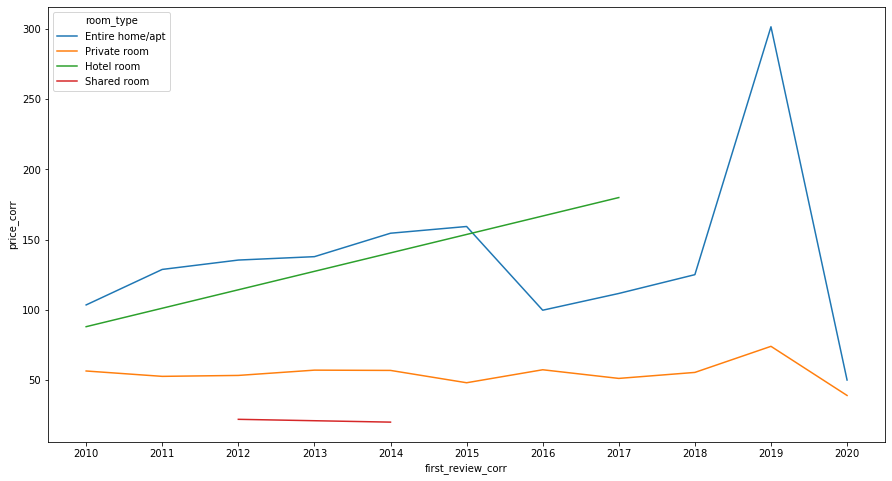

In [31]:
plt.figure(figsize=(15,8))
sns.lineplot(x='first_review_corr', y='price_corr', hue='room_type',
             data=q_test_agg)